# Qolor Qoding

Am Anfang müssen wir wieder ein paar Funktionen importieren, die wir verwenden wollen. Dafür musst Du die folgende Zelle einfach nur ausführen.

In [1]:
from matplotlib.pyplot import imshow, imsave
from copy import copy
from utils import load_image, reduce_rgb_values

Jetzt kommt noch etwas wichtiges zu Beginn: Hier müssen wir schon festlegen, wie viele Qubits wir verwenden wollen. Du kannst einen Wert zwischen `3` und `8` wählen. Aber fangen wir erstmal mit `3` an, diesen Wert kannst du später noch ändern. 

In [2]:
qubits = 1

## Bild laden

Zunächst müssen wir das Bild wieder laden. Das geht genauso wie eben. Auch die Größe lassen wir uns wieder anzeigen.

Das Bild hat folgende Dimensionen: (512, 512, 3)


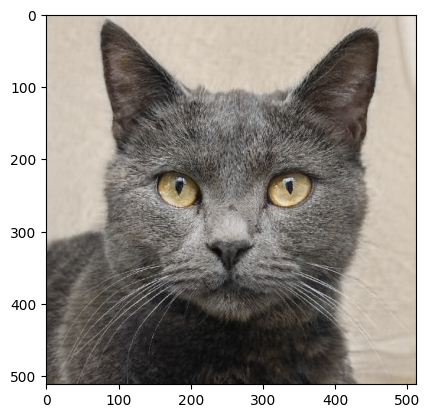

In [3]:
original_image = load_image("./images/Cat.jpg")
print("Das Bild hat folgende Dimensionen:", original_image.shape)

imshow(original_image)

## Werte reduzieren

Jetzt wird es ein wenig kompliziert. Farbwerte können ja Werte zwischen `0` und `255` annehmen. Ein Computer benötigt dafür genau `8 Bit` - also 8 Werte, die Null oder Eins sind. 

Diese acht Werte kriegen wir heute schon locker auf einen Quantencomputer, aber weniger wäre trotzdem besser. Denn weniger Werte bedeuten immer weniger Rechenaufwand - auf normalen Computern und auf Quantencomputern. 

Was und wie macht das der folgende Code Block? Hierfür ein kleines Beispiel. 

Stell dir vor, du willst einer Freundin eine zweistellige Zahl übermitteln, also zB. `63`. Dafür darfst du ihr aber nur eine einstellige Zahl mitteilen. Wie könntest du das machen? 

Nun - perfekt geht das nicht. Man kann nicht eine Nachricht schicken, die mehr Infos hat als Stellen. Man kann aber nah drankommen. Du könntest deine Zahl zum Beispiel auf die nächste Zehnerstelle runden und deiner Freundin dann die Zehnerstelle nennen, also `63` runden auf `60` und deiner Freundin dann die `6` nennen. Diese müsste dann `6` mit `10` multiplizieren und wüsste: "Die Zahl war ungefähr 60". 
Das ist natürlich nicht perfekt. Informationen gehen verloren, aber statt 2 Ziffern musst du nur eine übergeben - stell dir das mal in einem ganz großen Stil vor. 

Genau das macht die folgenden Funktion nur eben auf Basis von Bits. So sparen wir für jeden Pixelwert etliche Ziffern bzw. Bits - das sind Millionen für ein ganzes Bild! 

Führe die folgende Zelle einfach nur aus. Das Bild wird nach dieser Reduzierung ein bisschen anders aussehen, denn auch hier gehen ja Informationen und damit Details verloren. Wenn du das ganze noch besser verstehen willst, frag uns einfach :)

Wenn du ganz oben mehr qubits angegeben hast, gehen weniger Infos verloren, weil wir erlauben mehr zu übergeben. Bei `8` Qubits gibt es keinen Informationsverlust, dann dauert die Bildbearbeitung aber lange. 

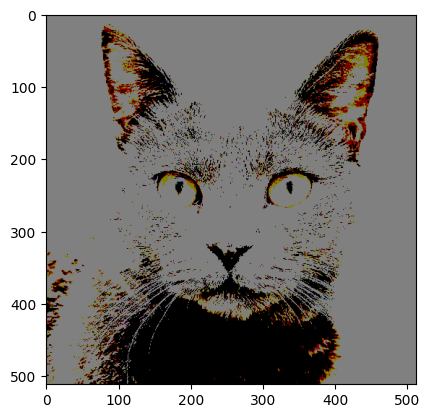

In [4]:
image = reduce_rgb_values(original_image, 2**(8-qubits))
imshow(image)

## Bildteile auswählen 

Wir können natürlich alle Pixel auf dem Quanten Computer bearbeiten lassen. Aber es kann auch cool aussehen nur Teile des Bildes umformen zu lassen. 

Im Folgenden erstellen wir dafür eine Liste, die alle Pixel Positionen beinhalten soll, die transformiert werden sollen. Wir nenne sie `pixels_to_transform`. Die Position eines Pixels wird auch wieder eine Liste mit seinen beiden Werten für Zeile und Spalte - also zB.: `[312, 250]`

Schreiben wir erstmal alle Pixel hinein. 

In [5]:
# Zunächst ist die Liste leer
pixels_to_transform = []

# jetzt fügen wir wieder mit zwei for Schleifen alle Pixel hinzu

for row in range(original_image.shape[0]):
    for column in range(original_image.shape[1]):
        pixel = [row, column]
        pixels_to_transform.append(pixel)
        
print("Finale Länge von 'pixels_to_transform'", len(pixels_to_transform))        
print(original_image.shape)

Finale Länge von 'pixels_to_transform' 262144
(512, 512, 3)


Da wir alle Pixel hinzugefügt haben, ist die Länge der Liste genau `Zeilen * Spalten` des Bildes. 

### Ein Rechteck auswählen

Um nur ein Rechteck zu verändern müssen wir die Position des oberen linken Pixels kennen und die Position des Pixels unten rechts. Alle Pixel, die dazwischen liegen gehören zum Rechteck dazu. 

Um das ganze umzusetzen, müssen wir aber noch etwas neues lernen zu der `range()` Funktion, die wir schon kennen. Wenn wir `range(5)` schreiben, erhalten wir ja `[0, 1, 2, 3, 4]`. Die Liste beginnt also bei `0` und der Wert, den wir angegeben haben, ist die obere Grenze. Man kann aber auch zwei Werte an `range()` übergeben. Dann ist der erste die untere Grenze und der zweite die obere:

In [6]:
for i in range(3, 7):
    print(i)

3
4
5
6


`range(5)` ist also genau das gleiche wie `range(0, 5)`. Führe die letzte Zelle gerne mehrmals mit unterschiedlichen Werten aus, um es besser zu verstehen. 

Mit diese Wissen können wir jetzt unseren Code von oben anpassen, um nur einen Teil des Bildes auszuwählen. Achte besonders darauf, wie sich die Übergabewerte von `range()` geändert haben. 

Vorher müssen wir aber natürlich festlegen, von wo nach wo unser Rechteck gehen soll. Dafür nutzen wir zwei Listen, die jeweils Zeile und Spalte der Pixel beinhalten. Kann man auch als x Wert und y Wert von zwei Punkten sehen - wie im Matheunterricht. 

Du musst natürlich darauf achten, dass die Punkte nicht außerhalb des Bildes liegen. Wir gucken uns in der Code Zelle vorher nochmal an, wie das Bild aussieht. Die Achsen können dir helfen ein Rechteck auszuwählen.

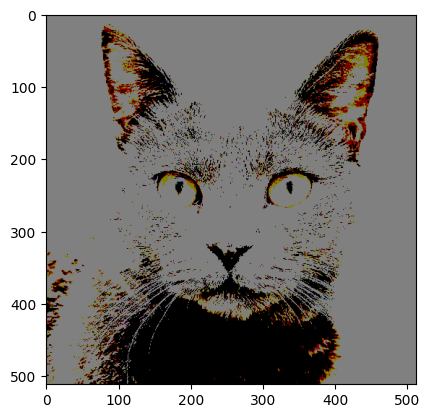

In [7]:
imshow(image)

In [8]:
# wir starten wieder mit einer leeren Liste
pixels_to_transform = []

# wir definieren das Rechteck
top_left = [30, 200]
bottom_right = [330, 500]

for row in range(top_left[0], bottom_right[0]):
    for column in range(top_left[1], bottom_right[1]):
        pixel = [row, column]
        pixels_to_transform.append(pixel)
        
print("Finale Länge von 'pixels_to_transform'", len(pixels_to_transform))        
print(original_image.shape)

Finale Länge von 'pixels_to_transform' 90000
(512, 512, 3)


Hat das jetzt funktioniert? Gucken wir uns nochmal alle Pixel an, die wir transformieren wollen. Dazu setzen wir sie einfach mal auf weiß. 

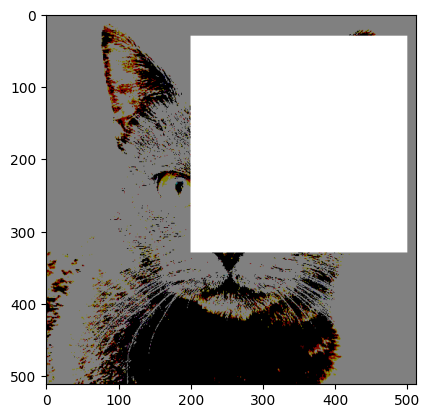

In [9]:
# als erstes erstellen wir eine Kopie, auf der wir Pixel weiß färben
# wir wollen ja nicht unser original verändern
image_copy = copy(image)

for pixel in pixels_to_transform:
    row = pixel[0]
    column = pixel[1]
    
    image_copy[row, column, 0] = 255 # R
    image_copy[row, column, 1] = 255 # G
    image_copy[row, column, 2] = 255 # B
    
imshow(image_copy)

**Aufgabe:** Schreibe nun deinen eigenen Code, der den oben ausgewaehlten Bildausschnitt nicht auf weiss setzt, sondern das Bild an der Stelle invertiert.

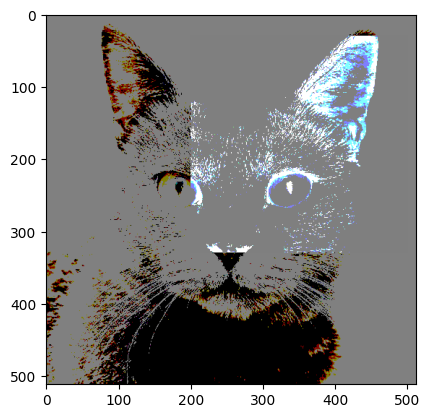

In [10]:
image_copy = copy(image)

for pixel in pixels_to_transform:
    row = pixel[0]
    column = pixel[1]
    
    # --- Ab hier dein Code ---
    image_copy[row, column, 0] = 255 - image_copy[row, column, 0] # R
    image_copy[row, column, 1] = 255 - image_copy[row, column, 1] # G
    image_copy[row, column, 2] = 255 - image_copy[row, column, 2] # B
    
    # -------------------------
    
imshow(image_copy)

Spiele damit gerne ein wenig herum. Das Rechteck kannst du beliebig wählen. Wenn du das gesamt Bild willst, führe einfach die entsprechende Zelle nochmal aus (die erste Code-Zelle im Abschnitt "Bildteile auswählen"). 

Die letzte Codezeile kannst du immer nochmal ausführen, um Dir anzeigen zu lasenn, was transformiert wird. 

## Es geht auf den Quantencomputer

Hier brauchen wir als erstes ganz viele Imports. Quanten Computer sind kompliziert ;)
Führe die folgende Zelle einfach nur aus.

In [11]:
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.random import random_circuit 
from qiskit.providers.fake_provider import FakeManilaV2, FakeBoeblingen, FakeMelbourne
from utils import filling_zeros, create_mapping, convert_image, convert_rgb_image, get_result, create_rgb_mapping

Ein wesentlicher Bestandteil zum Bedienen von den Quantencomputern wie wir sie heute verwenden möchten, ist die Definition des Quanten-Schaltkreises (Quantum Circuit).
Dieses gibt an wie die Information auf dem Quantencomputer verarbeitet werden. Du kannst dir das so ein bisschen vorstellen wie die einfachen Operation im allerersten Notebook heute, in dem wir pro Zeile den Wert einer Variable verändert haben.
Im dem Fall hier, wäre ein Qubit die Variable und jede Operation (jedes Gate) das wir darauf anwenden verändert diese Variable.

Lass uns mal ein ganz einfaches Beispiel machen. Wir erstellen uns ein Circuit mit nur einem einzigen Qubit und wollen dann den Zustand in dem es ganz am Anfang ist (man spricht von dem Grundzustand '0') invertieren.
Das Invertieren koennen wir mit einem sogenannten `X` gate erreichen, das wir einfach auf `quantum_circuit` aufrufen.

In [12]:
quantum_circuit = QuantumCircuit(1)
quantum_circuit.x(0)
quantum_circuit.draw()

┌───┐
q: ┤ X ├
   └───┘

Super Sache! Aber woher wissen wir denn nun ob das Qubit wirklich veraendert wurde?
Nun dazu muessen wir es messen. Das geschieht durch anhaengen eines Messoperators. Wir koennen allgemein beliebig viele Qubits messen, indem wir `measure_all()` auf dem Circuit aufrufen.

In [13]:
quantum_circuit = QuantumCircuit(1)
quantum_circuit.x(0)
quantum_circuit.measure_all()
quantum_circuit.draw()

┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

Jetzt muessen wir das ganze einmal ausfuehren und koennen uns das Ergebnis direkt anzeigen lassen.

In [14]:
result = get_result(quantum_circuit)

print(result)


{'1': 100}


Das laesst sich so interpretieren, als, dass der Zustand '1' in 100% der Faelle gemessen wurde.

Dann lass uns mal schauen, ob wir das bisherige Wissen ueber Quanten Computer schon auf Bilder uebertragen koennen.
Wir wissen ja jetzt, dass ein `X` Gate den Zustand unseres Qubits einmal umkehrt.
Das koennen wir nutzen um z.B. den Ausschnit aus unserem Katzenbild zu invertieren, genauso wie wir es in der Aufgabe zuvor gemacht haben.

**Aufgabe:** Schreibe eine For-Schleife in der du auf jedes der verfuegbaren Qubits ein `X` Gate anwendest

In [15]:
quantum_circuit = QuantumCircuit(qubits)

# --- Ab hier dein Code ---
for q in range(qubits):
    quantum_circuit.x(q)
# -------------------------

mapping = create_mapping(quantum_circuit)
q_image = convert_image(image, mapping, pixels_to_transform)
imshow(q_image)

Mapping: {'0': '1', '1': '0'}


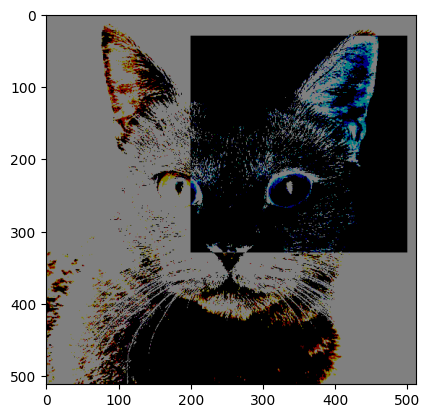

In [16]:
mapping = create_mapping(quantum_circuit)
q_image = convert_image(qubits, image, mapping, pixels_to_transform)
imshow(q_image)

Prima! Im Vergleich zu der "klassischen" Variante des invertierten Bildes sieht es aber etwas anders.

**Aufgabe:** Kannst du erklaeren wodurch der Unterschied entsteht?

Qubits sind für einen Quantencomputer übrigens das, was Bits für unsere klassischen Computer sind; Die kleinste Informationseinheit die wir mit diesen Geräten abbilden können.
Das Spannende ist nun, ein Qubit kann nicht nur entweder 0 oder 1 sein, sondern beides gleichzeitig mit einer gewissen Wahrscheinlichkeit. Klingt ein bisschen komisch?
Keine Sorge, die beiden Extrema ('0') und ('1') hast du ja bereits kennengelernt.

In [17]:
quantum_circuit = QuantumCircuit(3*qubits)

# --- Ab hier dein Code ---
quantum_circuit.swap(1,2)

# -------------------------

Mapping: {'000': '000', '001': '001', '010': '100', '011': '101', '100': '010', '101': '011', '110': '110', '111': '111'}


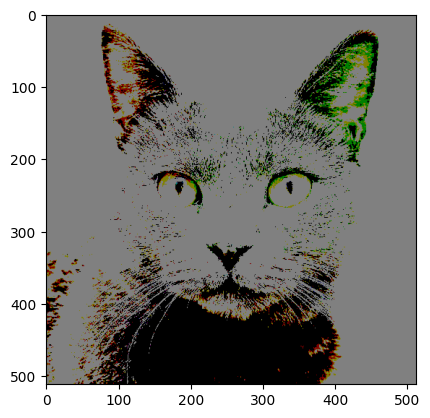

In [24]:



mapping = create_rgb_mapping(quantum_circuit)
q_image = convert_rgb_image(qubits, image, mapping, pixels_to_transform)
imshow(q_image)

In [ ]:
quantum_circuit = random_circuit(qubits, depth=4, max_operands=3, seed=1337)
quantum_circuit.draw()

┌─────┐┌──────────────────────────┐┌───┐┌───────────────────────────┐
q: ┤ Sdg ├┤ U3(1.1657,5.7862,5.9474) ├┤ H ├┤ U3(0.72723,1.2173,2.1472) ├
   └─────┘└──────────────────────────┘└───┘└───────────────────────────┘

In [ ]:
REPS = 2 # how often do you want to repeat your circuit ?
for i in range(REPS):
    quantum_circuit.compose(personal_circuit, inplace=True)
    quantum_circuit.barrier()
    quantum_circuit.compose(personal_circuit.inverse(), inplace=True)
    quantum_circuit.barrier()
    

NameError: name 'personal_circuit' is not defined

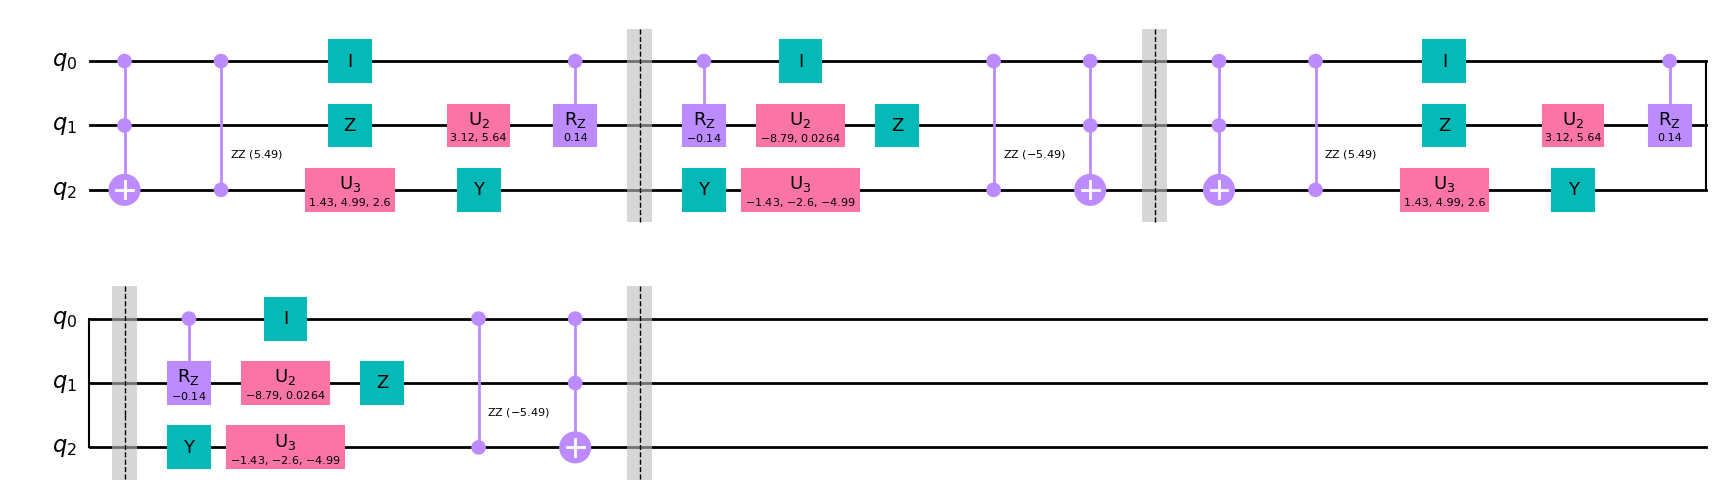

In [ ]:
quantum_circuit.draw()

## Erstelle dein eigenes Quantum Bild!

Mapping: {'000': '000', '001': '000', '010': '010', '011': '100', '100': '100', '101': '000', '110': '110', '111': '101'}


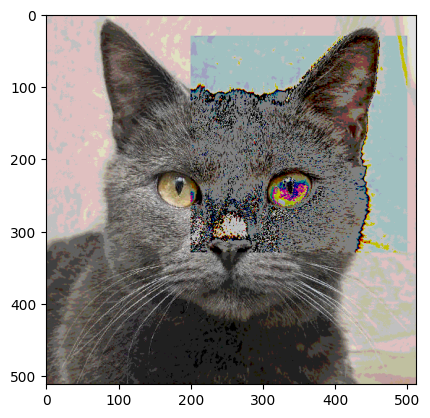

In [ ]:
backend = FakeMelbourne()
# backend = Aer.get_backend('qasm_simulator') # same image as output
shots = 4

mapping = create_mapping(noisy_circuit, backend, shots)
q_image = convert_image(n_qubits, image, mapping, pixels_to_transform)
imshow(q_image)

In [ ]:
plt.imsave("./results/cat.jpg", q_image)